## PED 1 - Notebook 2. Ajuste (spin-up) y respuesta a un forzamiento radiativo

En el Notebook 1 hemos entendido el modelo a nivel conceptual: qué ecuación representa, qué términos incluye (ASR, OLR y transporte meridional) y qué tipo de “clima” produce tras integrarlo en el tiempo.

En este Notebook 2 empezamos a **usar el modelo como laboratorio numérico**. El objetivo es trabajar con dos conceptos básicas de los modelos climáticos (sencillos o no):

1. **Spin-up (ajuste del modelo):**  
   antes de analizar resultados hay que integrar el modelo el tiempo suficiente para que alcance un régimen estable (en este caso, un régimen estacional periódico).   Esto plantea una pregunta práctica:     **¿cuántos años hay que integrar?**  En el Notebook 1 usamos “20 años” sin justiicarlo, ahora vamos a comprobar si ese valor es razonable o si es excesivo.

2. **Respuesta a un forzamiento radiativo:**  
   El cambio climático se produce por modificaciones del sistema (principalmente concentraciones de GEI) que modifican
el balance radiativo. Para tener esto en cuenta, el modelo permite introducir un forzamiento radiativo externo sencillo y observar cómo reponde el sistema modificando la temperatura.  


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import climlab


## Parámetros que vas a modificar en este cuaderno

En este notebook vamos a modificar dos cosas:

- **NYEARS_SPINUP**: número de años de integración para que el modelo se ajuste.
- **F**: forzamiento radiativo externo (en W m⁻²), que aplicaremos más adelante.

Empieza probando distintos valores de `NYEARS_SPINUP`. La idea es justificar un valor “suficiente” sin integrar de más.


In [2]:
# Número de años para el ajuste (spin-up). Cambia este valor.
NYEARS_SPINUP = 20

# Lista de valores alternativos para comparar (puedes modificarla)
SPINUP_TEST_YEARS = [1, 2, 5, 10]


## ¿Cómo decidimos si el spin-up es suficiente?

Para decidir si el modelo está ajustado vamos a observar dos cosas:

1. **Temperatura media global** (promedio sobre latitudes) año a año.  
   Si deja de cambiar apreciablemente, es una señal de que el sistema ya está cerca del régimen estacionario.

2. **Perfil latitudinal de temperatura** en algunos años representativos.  
   Si el perfil apenas cambia entre años sucesivos, la estructura espacial también se ha estabilizado.

La pregunta que debes responder al final de este bloque es:

**¿Qué valor mínimo de años de spin-up consideras razonable para este modelo y por qué?**


In [4]:
def run_spinup_diagnostics(nyears, Ts_init=None):
    m = climlab.EBM_seasonal()
    lat = m.state['Ts'].domain.axes['lat'].points
    
    # Condición inicial uniforme (si se especifica)
    if Ts_init is not None:
        m.state['Ts'][:] = Ts_init
    years = np.arange(nyears + 1)
    Tmean = np.zeros(nyears + 1)

    Ts0 = np.array(m.state['Ts']).ravel()
    Tmean[0] = float(np.mean(Ts0))

    for y in range(1, nyears + 1):
        m.integrate_years(1)
        Tsy = np.array(m.state['Ts']).ravel()
        Tmean[y] = float(np.mean(Tsy))

    return years, Tmean, lat, m


En la siguiente celda podemos **definimos las condiciones iniciales,** de momento, prueba con el valor 
por defecto, más adelante te pediremos que pruebes las otras opciones sugeridas y obtengas
los mismos gráfico para estos valores. 

In [ ]:
# Condición inicial de temperatura (°C)
# Opciones:
# None        -> condición inicial por defecto de climlab
# valor fijo  -> temperatura uniforme en todas las latitudes (por ejemplo -30 o +30)

Ts_initial = None   # prueba luego con 0.0, -30.0 o +30.0


Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.000000000000006 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.000000000000006 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.000000000000019 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 4.000000000000032 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 5.000000000000044 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.000000000000006 yea

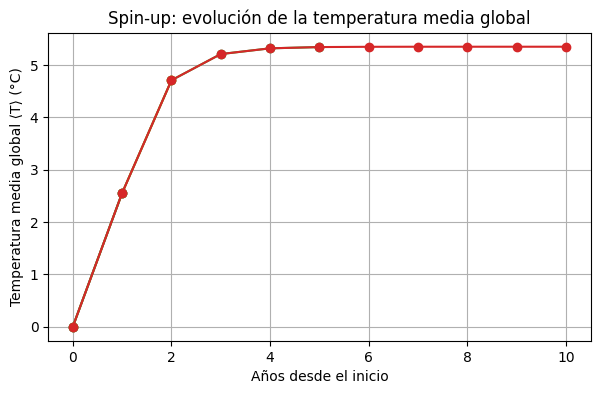

In [5]:
results = {}

for ny in SPINUP_TEST_YEARS:
    years, Tmean, lat, m_end = run_spinup_diagnostics(ny, Ts_init=Ts_initial)
    results[ny] = (years, Tmean, np.array(m_end.state['Ts']).ravel())

plt.figure(figsize=(7,4))
for ny in SPINUP_TEST_YEARS:
    years, Tmean, _ = results[ny]
    plt.plot(years, Tmean, marker='o', label=f"{ny} años")

plt.xlabel("Años desde el inicio")
plt.ylabel("Temperatura media global ⟨T⟩ (°C)")
plt.title("Spin-up: evolución de la temperatura media global")
plt.grid(True)
plt.show()


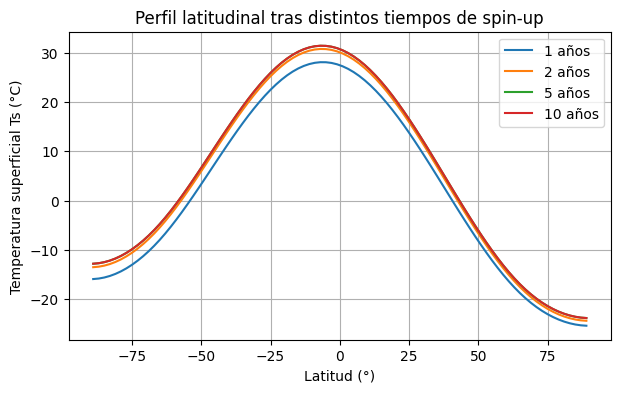

In [7]:
plt.figure(figsize=(7,4))
for ny in SPINUP_TEST_YEARS:
    _, _, Ts_end = results[ny]
    plt.plot(lat, Ts_end, label=f"{ny} años")

plt.xlabel("Latitud (°)")
plt.ylabel("Temperatura superficial Ts (°C)")
plt.title("Perfil latitudinal tras distintos tiempos de spin-up")
plt.grid(True)
plt.legend()
plt.show()


## Dependencia de la condición inicial

Hasta ahora hemos usado la condición inicial “por defecto” del modelo, que es realista al seguir la variación prevista por latitudes (como veíamos en el Notebook 1).  
Sin embargo, en un modelo climático una condición inicial realista puede ser muy difícil de estimar. 

Para comprobar el efecto de las condiciones iniciales vuelve a la celda anterior y ajusta, como se indica, las condiciones iniciales a valores uniformes (-30.0, 0.0 y 30.0).

Observa:
- si el tiempo de ajuste cambia,
- si el estado final es el mismo,
- si aparecen comportamientos transitorios poco realistas durante los primeros años.

Este tipo de pruebas son habituales en modelización climática y ayudan a decidir cuánto tiempo de spin-up es necesario.


A continuación tienes un código que hace esas comparaciones de forma automatizada para 
las diferentes condiciones iniciales.

Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9999999999999991 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 2.000000000000006 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 3.000000000000019 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 4.000000000000032 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 5.000000000000044 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 6.0000000000000355 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 6.999999999999992 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 7.999999999999949 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 8.999999999999906 years.
Integrating for 90 steps, 365.2422 days, or 1 years.
Total elapsed time is 9.999999999999863 years

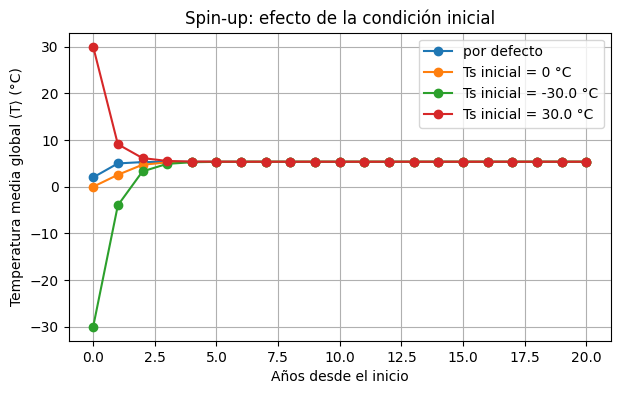

In [8]:
INITIAL_CONDITIONS = [None, 0, -30.0, +30.0]

plt.figure(figsize=(7,4))

for Ts0 in INITIAL_CONDITIONS:
    label = "por defecto" if Ts0 is None else f"Ts inicial = {Ts0} °C"
    years, Tmean, lat, _ = run_spinup_diagnostics(NYEARS_SPINUP, Ts_init=Ts0)
    plt.plot(years, Tmean, marker='o', label=label)

plt.xlabel("Años desde el inicio")
plt.ylabel("Temperatura media global ⟨T⟩ (°C)")
plt.title("Spin-up: efecto de la condición inicial")
plt.grid(True)
plt.legend()
plt.show()


### Preguntas para el informe de la PED 1

Con toda esta información para este modelo tan sencillo, responde a estas cuestiones:

1. ¿Cuánto tiempo tarda el modelo en alejarse del patrón de la condición inicial para converger a la solución final?
2. ¿Influye en algo la elección de unas condiciones iniciales realistas en una convergencia rápida? Razona por qué crees que esto será mucho más determinante en un modelo complejo (GCM) que en uno tan sencillo.    
